In [1]:
from google.colab import drive
drive.mount('/gdrive') 

Mounted at /gdrive


In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg16 import VGG16
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average, Input, Concatenate, GlobalMaxPooling2D,BatchNormalization
from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile, DenseNet169
from keras.applications.xception import Xception
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
from keras.models import Model
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools


%matplotlib inline

In [4]:
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG

In [5]:
normal_train = np.array(Dataset_loader('/content/drive/MyDrive/Binary Dataset/train/normal',224))
covid19_train = np.array(Dataset_loader('/content/drive/MyDrive/Binary Dataset/train/covid-19',224))
normal_test = np.array(Dataset_loader('/content/drive/MyDrive/Binary Dataset/test/normal',224))
covid19_test = np.array(Dataset_loader('/content/drive/MyDrive/Binary Dataset/test/covid-19',224))

100%|██████████| 86/86 [00:44<00:00,  1.95it/s]


In [7]:
print(len(normal_train))
print(len(covid19_train))
print(len(normal_test))
print(len(covid19_test))

1260
821
90
86


In [8]:
# Create labels
normal_train_label = np.zeros(len(normal_train))
covid19_train_label = np.ones(len(covid19_train))
normal_test_label = np.zeros(len(normal_test))
covid19_test_label = np.ones(len(covid19_test))

In [10]:
print(len(covid19_train_label))
print(len(covid19_test_label))
print(len(normal_test_label))

821
86
90


In [11]:
# Merge data 
X_train = np.concatenate((normal_train, covid19_train), axis = 0)
Y_train = np.concatenate((normal_train_label, covid19_train_label), axis = 0)
X_test = np.concatenate((normal_test, covid19_test), axis = 0)
Y_test = np.concatenate((normal_test_label, covid19_test_label), axis = 0)


In [12]:
print(len(X_train))
print(len(X_test))
print(len(Y_test))

2081
176
176


In [13]:
# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]


In [14]:
# To categorical
Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

In [15]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=11
)

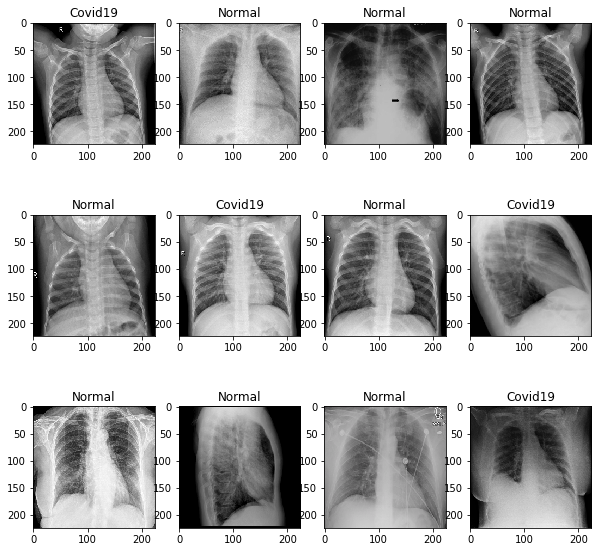

In [20]:
# # Display first 15 images of moles, and how they are classified
w=60
h=40
fig=plt.figure(figsize=(10,10))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Normal')
    else:
        ax.title.set_text('Covid19')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

In [21]:
BATCH_SIZE = 32

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2.5,  # set range for random zoom
        rotation_range = 90,
        shear_range = 0.5,
        width_shift_range=0.5,
        height_shift_range=0.5,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True  # randomly flip images
    )

In [22]:
IMAGE_SIZE=224
# Model
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
inputs = Input(input_shape)
 
dennet  = DenseNet169(include_top=False, input_shape=input_shape)(inputs)
resnet  = ResNet50(include_top=False, input_shape=input_shape)(inputs)
vgg     = VGG19(include_top=False, input_shape=input_shape)(inputs)

80142336/80134624 [==============================] - 1s 0us/step


In [23]:
outputs = Concatenate(axis=-1)([GlobalAveragePooling2D()(dennet), GlobalAveragePooling2D()(resnet), GlobalAveragePooling2D()(vgg)])
outputs = Dropout(0.4)(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(256,activation='relu')(outputs) 
outputs = Dense(128,activation='relu')(outputs) 
outputs = Dropout(0.2)(outputs)
outputs = Dense(2, activation='softmax')(outputs)

model = Model(inputs, outputs)
model.compile(optimizer=Adam(lr=0.0001, decay=0.00001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
densenet169 (Functional)        (None, 7, 7, 1664)   12642880    input_1[0][0]                    
__________________________________________________________________________________________________
resnet50 (Functional)           (None, 7, 7, 2048)   23587712    input_1[0][0]                    
__________________________________________________________________________________________________
vgg19 (Functional)              (None, 7, 7, 512)    20024384    input_1[0][0]                    
_______________________________________________________________________________________

In [24]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="/content/drive/MyDrive/best_binary_multinet.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [25]:
history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=40,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/40
52/52 [==============================] - 40s 768ms/step - loss: 0.3972 - accuracy: 0.8083 - val_loss: 0.0962 - val_accuracy: 0.9736
Epoch 2/40
52/52 [==============================] - 35s 680ms/step - loss: 0.2120 - accuracy: 0.9087 - val_loss: 0.2652 - val_accuracy: 0.9353
Epoch 3/40
52/52 [==============================] - 35s 682ms/step - loss: 0.1943 - accuracy: 0.9243 - val_loss: 0.2234 - val_accuracy: 0.9376
Epoch 4/40
52/52 [==============================] - 36s 684ms/step - loss: 0.1820 - accuracy: 0.9297 - val_loss: 0.1163 - val_accuracy: 0.9688
Epoch 5/40
52/52 [==============================] - 35s 681ms/step - loss: 0.1634 - accuracy: 0.9261 - val_loss: 0.1295 - val_accuracy: 0.9592
Epoch 6/40
52/52 [==============================] - 35s 681ms/step - loss: 0.1508 - accuracy: 0.9423 - val_loss: 0.0700 - val_accuracy: 0.9736
Epoch 7/40
52/52 [==============================] - 35s 682ms/step

In [26]:
Y_pred = model.predict(X_test)

Confusion matrix, without normalization
[[89  1]
 [ 0 86]]


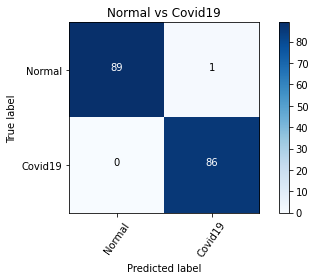

In [27]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['Normal', 'Covid19']
plot_confusion_matrix(cm, cm_plot_label, title ='Normal vs Covid19')

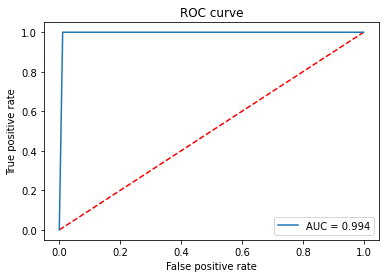

In [28]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()

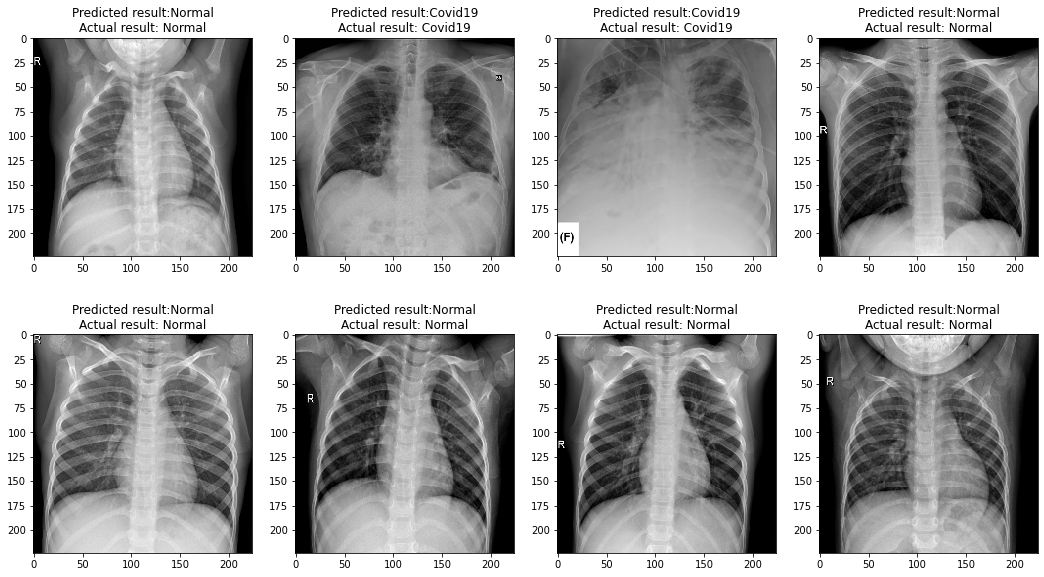

In [29]:
i=0
prop_class=[]
mis_class=[]

for i in range(len(Y_test)):
    if(np.argmax(Y_test[i])==np.argmax(Y_pred[i])):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(Y_test)):
    if(not np.argmax(Y_test[i])==np.argmax(Y_pred[i])):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

# # Display first 8 images of benign
w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==0:
        return "Normal"
    else:
        return "Covid19"
    
for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(np.argmax(Y_pred[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(Y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
plt.show()

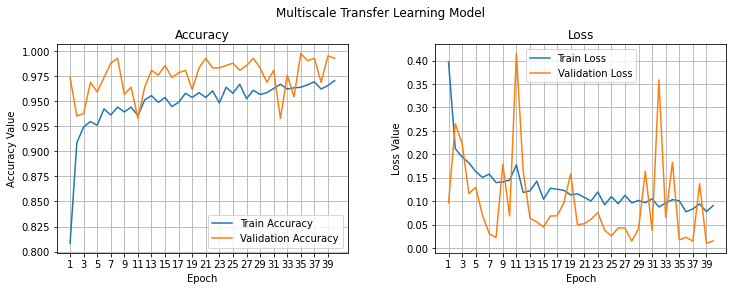

In [33]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Multiscale Transfer Learning Model', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,41))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.grid()
ax1.set_xticks(np.arange(1, 41, 2))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.grid()
ax2.set_xticks(np.arange(1, 41, 2))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [35]:
pred=model.predict(X_test)
Y_pred = np.argmax(pred, 1)
y_test=np.argmax(Y_test,1)

In [36]:
from sklearn.metrics import classification_report, confusion_matrix
print('Classification Report')
target_names = ['Normal', 'Covid19']
print(classification_report(y_test, Y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

      Normal       1.00      0.99      0.99        90
     Covid19       0.99      1.00      0.99        86

    accuracy                           0.99       176
   macro avg       0.99      0.99      0.99       176
weighted avg       0.99      0.99      0.99       176

